## Задача

Реализуйте один алгоритм повышения резкости фотографии отсюда https://web.stanford.edu/class/cs448f/lectures/2.1/Sharpening.pdf , на свой выбор. Результат пришлите в виде кода и нескольких примеров работы. Вы можете взять нерезкие фотографии, например, тут https://unsplash.com/search/photos/blurred Почему вы выбрали именно этот алгоритм?

**Из-за простоты, выбран подход, использующий фильтр с гауссовым ядром.**

## Результаты

1. Небольшое улучшение на картинке с искуственным шумом
2. Нет улучшения на реальном фото. Возможные причины (следуя https://stackoverflow.com/questions/53743561/deblurring-an-image):
    - исходный блюр (размытый фокус на фото) не является одим сверточным преобразованием (как минимум композицией)
    - дополнительные шумы
3. наивная реализация довольно медленная
    - можно переписать под numpy
    - можно вынести на GPU


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from imgaug.augmenters import Sharpen, GaussianBlur, MedianBlur
import imgaug
from scipy import ndimage
import scipy.stats as st

# Linear Sharpening with Gaussian Kernel Filter

In [2]:
# спасибо SO 
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()
gkern(3, 2.)

array([[0.05793362, 0.1248268 , 0.05793362],
       [0.1248268 , 0.26895831, 0.1248268 ],
       [0.05793362, 0.1248268 , 0.05793362]])

In [3]:
def idkern(kernlen=21):
    """Returns a 2D Identity kernel."""
    res = np.zeros((kernlen, kernlen), dtype=np.float32)
    center = (kernlen - 1) // 2
    res[center, center] = 1.
    return res
idkern(5)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [4]:
def convolve_channel(im_channel, kernel):
    H, W = im_channel.shape[:2]
    ksize = kernel.shape[0]
    result = np.zeros_like(im_channel)
    pad = (ksize - 1) // 2
    im_padded = np.pad(im_channel, (pad,), #[(0,0), (0,0), (pad, pad), (pad, pad)],
                       mode='constant', constant_values=(0.,))
    #print(im_padded.shape)
    #plt.imshow(im_padded, cmap='gray')
    #plt.show()
    for h_out in range(H):
        for w_out in range(W):
            xx = im_padded[h_out : h_out + ksize,
                           w_out : w_out + ksize ]
            assert(xx.shape == kernel.shape)
            result[h_out, w_out] = np.sum(kernel * xx)
    return result

def convolve_image(im, kernel):
    result = np.zeros_like(im)
    for channel in range(im.shape[2]):
        im_channel = im[..., channel]
        result[..., channel] = convolve_channel(im_channel, kernel)
    return result

def deblur(im, ksize, sigma=2.):
    identity_kernel = idkern(ksize)
    gaus_kernel = gkern(ksize, sigma)
    deblur_kernel = 1.5 * identity_kernel - .5 * gaus_kernel
    return convolve_image(im, deblur_kernel)


(200, 183, 3) 1.0


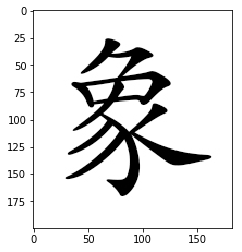

In [5]:
test_im = plt.imread('blurred/chinese.png')[...,:3] # 1.0 - plt.imread('blurred/chinese.png')[...,:3]
print(test_im.shape, test_im.max())
plt.imshow(test_im)

**Проверим, что единичное ядро не меняет изображение**

In [6]:
idkern_im = convolve_image(test_im, idkern(7))
print(np.all(idkern_im == test_im))
#plt.imshow((idkern_im == test_im).astype(np.uint8), cmap='gray')

True


# Тест 1

Blurred 0.99999994


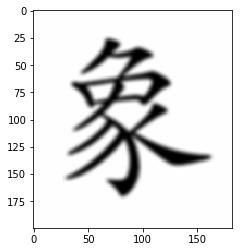

In [7]:
blurred_im = GaussianBlur(sigma=2., deterministic=True).augment_image(test_im) # convolve_channel(im_ch, gaus_kernel)
print('Blurred', blurred_im.max())
plt.imshow(blurred_im)


De-Blurred 1.1460694


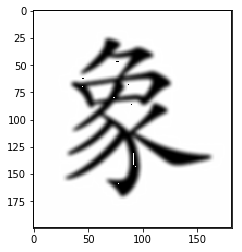

In [8]:
deblurred_im = deblur(blurred_im, ksize=7, sigma=7.)
print('De-Blurred', deblurred_im.max())
plt.imshow(deblurred_im)

# Тест 2

(2304, 3382, 3) 0 255
De-Blurred 255


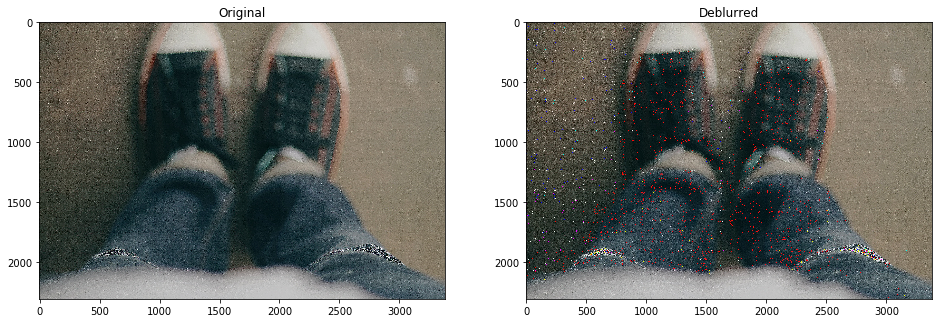

In [10]:
_, ax = plt.subplots(1, 2, figsize=(16, 12))
im = plt.imread('blurred/legs.jpg')
print(im.shape, im.min(), im.max())
ax[0].imshow(im)
ax[0].set_title('Original')

deblurred_im = deblur(im, ksize=7, sigma=7.)
print('De-Blurred', deblurred_im.max())
ax[1].imshow(deblurred_im)
ax[1].set_title('Deblurred')